In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import warnings
from scipy import stats
import time

In [2]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  64


In [3]:
# Read and split the data
data = pd.read_csv("./mydata/loans.csv")
data = data.dropna()
data = data.sample(frac=1)
feature_name_list = list(data.columns)[2:]
outcome_name = 'SeriousDlqin2yrs'
total_offline_pop = 1000
offline_pop = data[:total_offline_pop]
online_pop = data[total_offline_pop:]
online_pop_size = online_pop.shape[0]

nonactionable_features = ['age', 'NumberOfDependents']
actionable_feature_inds = [feature_name_list.index(feature) 
                           for feature in feature_name_list if feature not in nonactionable_features]
num_actionable_features = len(actionable_feature_inds)


In [4]:
list(data.columns), feature_name_list

(['Unnamed: 0',
  'SeriousDlqin2yrs',
  'RevolvingUtilizationOfUnsecuredLines',
  'age',
  'NumberOfTime30-59DaysPastDueNotWorse',
  'DebtRatio',
  'MonthlyIncome',
  'NumberOfOpenCreditLinesAndLoans',
  'NumberOfTimes90DaysLate',
  'NumberRealEstateLoansOrLines',
  'NumberOfTime60-89DaysPastDueNotWorse',
  'NumberOfDependents'],
 ['RevolvingUtilizationOfUnsecuredLines',
  'age',
  'NumberOfTime30-59DaysPastDueNotWorse',
  'DebtRatio',
  'MonthlyIncome',
  'NumberOfOpenCreditLinesAndLoans',
  'NumberOfTimes90DaysLate',
  'NumberRealEstateLoansOrLines',
  'NumberOfTime60-89DaysPastDueNotWorse',
  'NumberOfDependents'])

Text(0.5, 1.0, 'NumberOfOpenCreditLinesAndLoans')

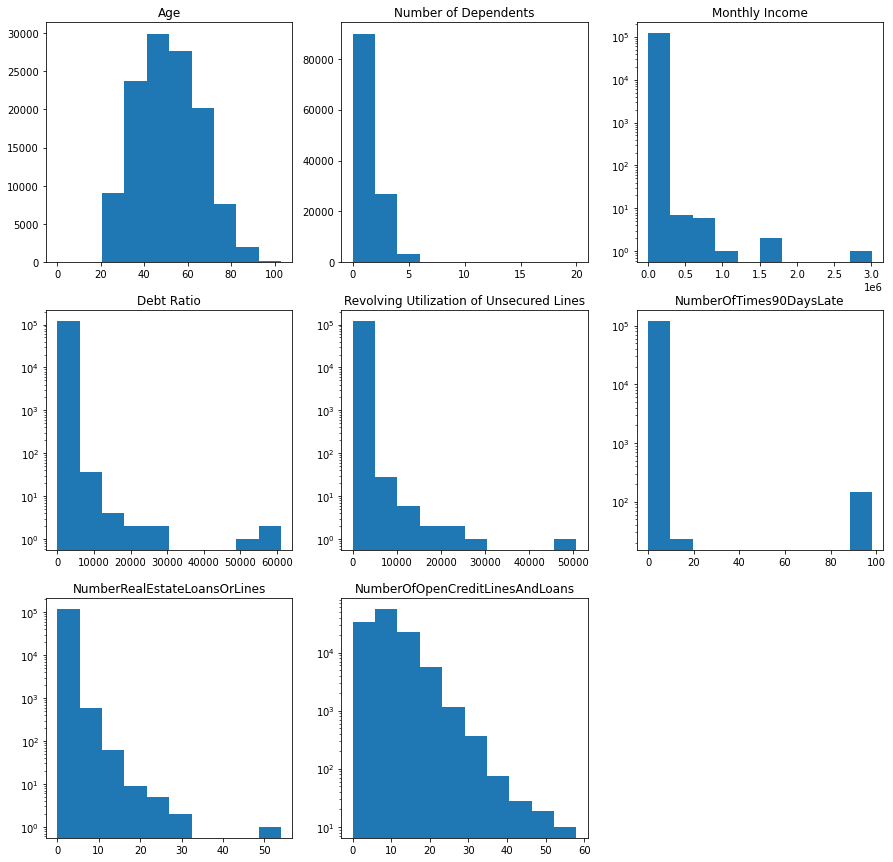

In [5]:
# Visualizing the feature distributions. Notice that 
plt.figure(figsize=(15,15))
plt.subplot(3, 3, 1)
plt.hist(data.age)
plt.title("Age")
plt.subplot(3, 3, 2)
plt.hist(data.NumberOfDependents)
plt.title("Number of Dependents")
plt.subplot(3, 3, 3)
plt.hist(data.MonthlyIncome)
plt.yscale("log")
plt.title("Monthly Income")
plt.subplot(3, 3, 4)
plt.hist(data.DebtRatio)
plt.yscale("log")
plt.title("Debt Ratio")
plt.subplot(3, 3, 5)
plt.hist(data.RevolvingUtilizationOfUnsecuredLines)
plt.title("Revolving Utilization of Unsecured Lines")
plt.yscale("log")
plt.subplot(3, 3, 6)
plt.hist(data.NumberOfTimes90DaysLate)
plt.yscale("log")
plt.title("NumberOfTimes90DaysLate")
plt.subplot(3, 3, 7)
plt.hist(data.NumberRealEstateLoansOrLines)
plt.yscale("log")
plt.title("NumberRealEstateLoansOrLines")
plt.subplot(3, 3, 8)
plt.hist(data.NumberOfOpenCreditLinesAndLoans)
plt.yscale("log")
plt.title("NumberOfOpenCreditLinesAndLoans")

In [122]:
## Find nearest neighbor ##
# First "normalize" data by converting to percentiles #
offline_pop_features = offline_pop[feature_name_list].to_numpy()
# max_features = np.max(selected_data[feature_name_list]).to_numpy()
normalized_offline_pop_features = stats.rankdata(offline_pop_features, axis=0) / offline_pop_features.shape[0]
# Flip age and income so that higher percentile -> higher chance of default.
flip_feature_inds = [feature_name_list.index("age"), feature_name_list.index("MonthlyIncome")]
normalized_offline_pop_features[:, flip_feature_inds] = 1 - normalized_offline_pop_features[:, flip_feature_inds]

### Some Helper Functions ###
def logit(p):
    """ Domain: (0, 1), Range: (-inf, inf). """
    return np.log(p) - np.log(1 - p)

def inv_logit(p):
    """ Domain: (-inf, inf), Range: (0, 1). """
    with warnings.catch_warnings(): # catch 'not DPP' warnings
        warnings.simplefilter("ignore")
        exp_p = np.exp(p)
        return np.where(exp_p == np.inf, 1, exp_p / (1 + exp_p))

def whiten(ary):
    return (ary - np.mean(ary, axis=0)) / np.std(ary, axis=0)

def rmse(yhat, y):
    return np.sqrt(np.mean((yhat - y)**2))

def get_offline_pop_MLE_reward_ests(model):
    """ Use model to compute MLE reward ests for the offline population. """
    # Manually compute probabilities for efficiency.
    coeffs = model.coef_.T # column vector
    intercept = model.intercept_
    logits = normalized_offline_pop_features @ coeffs + intercept
    MLE_reward_ests = inv_logit(logits)
    return MLE_reward_ests

### Computing Reward Estimates from Data ###
def logistic_exploration_bonus(inv_unnorm_cov, t, a, b, c):
    """ Use the inverse unnormalized covariance matrix to compute an exploration bonus. """
    bonuses = np.array([(feature.reshape(1, -1) @ inv_unnorm_cov @ feature.reshape(-1, 1))[0]
                       for feature in normalized_offline_pop_features])
        
    rho_t = a + b * num_features/2 * np.log(1 + t/c)
#     rho_t = 1
    return np.sqrt(bonuses * rho_t)

def pointwise_opt_reward_ests(mle_rewards, inv_unnorm_cov, t, a, b, c): 
    return mle_rewards + logistic_exploration_bonus(inv_unnorm_cov, t, a, b, c)
    
def get_nn(person_normalized_features):
    """ Return row # of offline individual most 'similar' to person, 
        using L2 (normalized) feature distance. Assume person's features are already normalized. """    
    l2_dists = np.linalg.norm(person_normalized_features-normalized_offline_pop_features, ord=2, axis=1)
    return np.argmin(l2_dists)

def normalize_features_by_offline_pop(person_features):
    normalized_features = []
    for feature_name in feature_name_list:
        offline_pop_features_col = offline_pop_features[:, feature_name_list.index(feature_name)]
        person_feature = person_features[feature_name_list.index(feature_name)]
        percentile = stats.percentileofscore(offline_pop_features_col, person_feature)
        normalized_features.append(percentile/100)
    normalized_features = np.array(normalized_features)
    normalized_features[flip_feature_inds] = 1 - normalized_features[flip_feature_inds]
    return normalized_features
# Test nn
person = online_pop[200:201]
person_normalized_features = normalize_features_by_offline_pop(person[feature_name_list].to_numpy().reshape(-1))
person, offline_pop.iloc[get_nn(person_normalized_features)]

(       Unnamed: 0  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  \
 13746       13747                 0                              0.660956   
 
        age  NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
 13746   66                                     3   0.203015         2851.0   
 
        NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
 13746                                7                        0   
 
        NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
 13746                             0                                     1   
 
        NumberOfDependents  
 13746                 0.0  ,
 Unnamed: 0                              121020.000000
 SeriousDlqin2yrs                             0.000000
 RevolvingUtilizationOfUnsecuredLines         0.340139
 age                                         49.000000
 NumberOfTime30-59DaysPastDueNotWorse         1.000000
 DebtRatio                                    0.1713

In [7]:
# Normalize online population
normalized_online_pop_features = []
for online_feature in tqdm(online_pop[feature_name_list].to_numpy()):
    normalized_online_pop_features.append(normalize_features_by_offline_pop(online_feature) )
normalized_online_pop_features = np.array(normalized_online_pop_features)

100%|██████████| 119269/119269 [00:13<00:00, 8539.23it/s]


In [8]:
# Test how well-specified logistic regression is
oracle_model = LogisticRegression(max_iter=int(1e4), solver='liblinear').fit(
    normalized_online_pop_features, online_pop[outcome_name])
acc = oracle_model.score(normalized_offline_pop_features, offline_pop[outcome_name])
acc1 = oracle_model.score(
    normalized_offline_pop_features[offline_pop[outcome_name] == 1], offline_pop[outcome_name][offline_pop[outcome_name] == 1])
acc0 = oracle_model.score(
    normalized_offline_pop_features[offline_pop[outcome_name] == 0], offline_pop[outcome_name][offline_pop[outcome_name] == 0])
print(acc, acc1, acc0) # note that false negative rate is very high, because proportion of positives in data is very low.
print(oracle_model.coef_) # verify that all coefficients are positive. We will use this fact for the recourse calculations.

0.936 0.2 0.9913978494623656
[[2.46448211 0.69866937 1.88210574 0.25140654 0.49493804 0.56172614
  3.10273291 0.0642712  1.94053554 0.20103343]]


In [140]:
### DGP Parameters ###
num_actions = 2
num_features = len(feature_name_list)
loan_cost = 10
outcome_label = "SeriousDlqin2yrs"

deliquency_oracle_preds = get_offline_pop_MLE_reward_ests(oracle_model)
oracle_offline_rew_preds = (np.hstack([
    np.zeros((total_offline_pop, 1)),
    1-deliquency_oracle_preds - loan_cost * deliquency_oracle_preds]) + loan_cost) / (loan_cost + 1)

## Simulation ##
def loan_reward(action, outcome):
    """Normalize reward to be between [0, 1]. """
    unnorm_reward = 0
    if action == 1:
        if outcome == 1:
            unnorm_reward = -loan_cost
        else:
            unnorm_reward = 1
    else:
        unnorm_reward = 0
    return (unnorm_reward + loan_cost) / (loan_cost + 1)

def run_simulation(policy_optimizer, total_online_pop = 1000, batch_size=0, warmup_batch_size=10):
    """ Differences from other exps: only get feedback when a loan is given. Cost of giving a loan and 
    having the person default is 5, otherwise gain 1. Not giving a loan gets 0 cost. """
    np.random.seed() # set random seed for parallelization
    a, b, c = 5, 5, total_online_pop # set confidence set 

    # Pretrain model with warmup batch. Make sure covariance matrix is invertible.
    random_actions = np.ones((warmup_batch_size, 1)) # only give loans
    condition = True
    while condition:
        warmup_batch = online_pop.sample(warmup_batch_size)
        features = warmup_batch[feature_name_list].to_numpy()
        features = [normalize_features_by_offline_pop(feature) for feature in features]
        unnorm_cov = sum([np.outer(feature, feature) for feature in features])
        outcomes = warmup_batch[outcome_label].to_numpy(dtype=int).reshape(-1, 1)
        condition = np.linalg.matrix_rank(unnorm_cov) < num_features or np.sum(outcomes) == 0
    data = np.hstack([warmup_batch.to_numpy(), random_actions])
    logreg_model = LogisticRegression(solver='lbfgs', warm_start=True)
    model = logreg_model.fit(features, outcomes.reshape(-1))
    rewards = [loan_reward(action, outcome) for action, outcome in zip(random_actions, outcomes)]

    inv_unnorm_cov = np.linalg.inv(sum([np.outer(feature, feature) for feature in features]))

    # Run simulation #
    est_utility_vals = []
    oracle_pihat_utility_vals = []
    oracle_pistar_utility_vals = []
    update = True
    num_model_updates, num_policy_updates = 0, 0
    for t in tqdm(range(total_online_pop)):
        if batch_size:
            update_model = ((t % batch_size) == 0) or update_model
            update_policy = ((t % batch_size) == 0)
        new_person = online_pop.sample(1)

        with warnings.catch_warnings(): # catch 'not DPP' warnings
            warnings.simplefilter("ignore")
            if update_policy:
                # Compute the contextual policy and person-conditioned action distribution.
                mle_preds = get_offline_pop_MLE_reward_ests(model)
                mle_rewards = (np.hstack([
                    np.zeros((total_offline_pop, 1)),
                    1-mle_preds - loan_cost * mle_preds]) + loan_cost) / (loan_cost + 1)
                reward_ests = pointwise_opt_reward_ests(mle_rewards, inv_unnorm_cov, t, a=a, b=b, c=c)
                reward_bonuses = logistic_exploration_bonus(inv_unnorm_cov, t, a=a, b=b, c=c)
                try:
                    computed_policy, utility_fn, reward_params, problem = policy_optimizer(
                        reward_ests, False)
                except:
                    computed_policy, utility_fn, reward_params, problem = policy_optimizer(
                        reward_ests, True)
                num_policy_updates += 1

        # Get values
        reward_params.value = reward_ests
        est_utility_vals.append(utility_fn.value)
        reward_params.value = oracle_offline_rew_preds
        oracle_pihat_utility_vals.append(utility_fn.value)
        
        new_feature = normalize_features_by_offline_pop(
            new_person[feature_name_list].to_numpy().reshape(-1))
        nn_id = get_nn(new_feature) 
        action_dist = computed_policy[nn_id, :]
        

        # Sample the action and reward
        try:
            action_taken = np.random.multinomial(1, action_dist).nonzero()[0][0]
        except:
            action_dist /= sum(action_dist) # correct for rounding errors
            print(action_dist)
            action_taken = np.random.multinomial(1, action_dist).nonzero()[0][0]
            
        # Only observe outcome is loan is given.
        new_outcome = new_person[outcome_label].to_numpy(dtype=int).reshape(-1, 1)
        if action_taken == 1:
            features = np.vstack([features, new_feature.T])
            outcomes = np.vstack([outcomes, new_outcome.T])
            if update_model:
                model = logreg_model.fit(features, outcomes.reshape(-1))
                acc = model.score(normalized_offline_pop_features, offline_pop[outcome_name])
                acc1 = model.score(
                    normalized_offline_pop_features[offline_pop[outcome_name] == 1], 
                    offline_pop[outcome_name][offline_pop[outcome_name] == 1])
                acc0 = model.score(
                    normalized_offline_pop_features[offline_pop[outcome_name] == 0], 
                    offline_pop[outcome_name][offline_pop[outcome_name] == 0])
                num_model_updates += 1
                update_model = False

            # Update inverse unnorm cov matrix according to Sherman-Morrison formula.
            inv_unnorm_cov -= inv_unnorm_cov @ np.outer(new_feature, new_feature) @ inv_unnorm_cov / \
                            (1 + new_feature.T @ inv_unnorm_cov @ new_feature)


        reward = loan_reward(action_taken, new_outcome)
        rewards = np.hstack([rewards, [reward]])
        data = np.vstack([data, np.hstack([new_person.to_numpy(), [[action_taken]]])])
        

    values = [est_utility_vals, oracle_pihat_utility_vals] 
    return values, rewards, data, mle_rewards, computed_policy

simulation_columns = ['values', 'rewards', 'data', 'mle_rewards']

In [134]:
def compute_opt_policy_reward_max(reward_ests, verbose=False):
    """ Compute policy which maximizes rewards. Takes as input reward estimates and budget constraint. """
    # Shared policy optimization structure
    policy_var = cp.Variable((total_offline_pop, num_actions), nonneg=True)
    reward_params = cp.Parameter((total_offline_pop, num_actions), nonneg=True)

    basic_cstrs = [cp.sum(policy_var, axis=1) <= 1]

    avg_per_person_rew = cp.sum(cp.multiply(reward_params, policy_var), axis=1)
    exp_rew = cp.sum(avg_per_person_rew)/total_offline_pop
    
    faster_compile_param = cp.Parameter(nonneg=True)
    faster_compile_param.value = 1
    
    utility_fn = faster_compile_param * exp_rew # for some reason multiplying by the param makes the problem compile faster??
    opt_problem = cp.Problem(cp.Maximize(utility_fn), basic_cstrs)
    
    reward_params.value = reward_ests
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        opt_problem.solve(verbose=verbose, solver=cp.ECOS, feastol=1e-4, reltol=1e-4, abstol=1e-4)
    return policy_var.value, utility_fn, reward_params, opt_problem

## Oracle utility rew max ##
oracle_policy, utility_fn, reward_params, problem = compute_opt_policy_reward_max(oracle_offline_rew_preds)
oracle_utility_rew_max = utility_fn.value
print(oracle_utility_rew_max * (oracle_utility_rew_max + loan_cost) / (loan_cost + 1))

0.9542799136648307


In [215]:
## Compute Oracle Rewards ##
online_features = normalized_online_pop_features
nns = [get_nn(feature) for feature in online_features]
defaulted_online = online_pop[outcome_label]

def compute_actual_reward(policy):
    """ Returns the (un)normalized rewards actually achieved by a policy. """
    loan_probs = [policy[nn, 1] for nn in nns]
    unnorm_online_rewards = ((1-defaulted_online) - loan_cost * defaulted_online) * loan_probs
    norm_online_rewards = (unnorm_online_rewards + loan_cost) / (loan_cost + 1)
    return np.mean(unnorm_online_rewards), np.mean(norm_online_rewards), stats.sem(unnorm_online_rewards), stats.sem(norm_online_rewards)

### Compute recourse ###
norm_online_act_features = normalized_online_pop_features[:, actionable_feature_inds]
online_nns = []
for norm_online_feat in tqdm(normalized_online_pop_features):
    online_nns.append(get_nn(norm_online_feat))
online_nns = np.array(online_nns)


def get_recourse(policy, num_samples=1000):
    """ Compute delta prob/delta percentile of a policy using the online pop. """
    recourses = []
    give_loan_probs = policy[:, 1]
    total_num_comparisons = 0
    sampled_ids = np.random.choice(list(range(online_pop_size)), size=num_samples, replace=False)
    for person_id in tqdm(sampled_ids):
        person_act_feat = norm_online_act_features[person_id]
        person_feat = normalized_online_pop_features[person_id]
        person_give_loan_prob = give_loan_probs[online_nns[person_id]]
        if person_give_loan_prob > 0.9:
            pass
        # Get ids of people who have monotonically `better' features, i.e. less likely to default.
        better_act_feat_inds = np.where(np.logical_and(
            np.sum(person_act_feat >= norm_online_act_features, axis=1) == num_actionable_features,
            np.sum(np.round(person_act_feat, 4) == np.round(norm_online_act_features, 4), axis=1) != num_actionable_features))[0]
        if len(better_act_feat_inds) == 0:
            # pass if no one has better features
            pass
        better_act_feat_inds = np.random.choice( # sample the set of people with better features
            better_act_feat_inds, size=min(num_samples, len(better_act_feat_inds)), replace=False)
        total_num_comparisons += len(better_act_feat_inds)
        
        # compute "cost" of becoming like the better person
        better_act_features = norm_online_act_features[better_act_feat_inds]
        perc_shifts = np.sum(person_act_feat - better_act_features, axis=1) * 100
        
        # Compute gain in probability of becoming like the better person
        better_loan_probs = give_loan_probs[online_nns[better_act_feat_inds]]
        better_delta_probs = better_loan_probs - person_give_loan_prob
        
        # compute recourse
        try:
            recourse = np.max(better_delta_probs/perc_shifts)
        except:
            pass
        recourses.append(recourse)
    return np.mean(recourses), stats.sem(recourses), total_num_comparisons


print(compute_actual_reward(oracle_policy))

100%|██████████| 119269/119269 [00:05<00:00, 23713.75it/s]


(0.5296872411143038, 0.9572442946467309, 0.005311950501129946, 0.0004829045910118133)


In [142]:
# reward you would get if you gave everyone a loan
naive_rewards_online = (1 - defaulted_online) - loan_cost * defaulted_online
print(np.mean(naive_rewards_online), stats.sem(naive_rewards_online))
avg_loanall_reward_online = np.mean(naive_rewards_online)
avg_loanall_norm_reward_online = (avg_loanall_reward_online + loan_cost) / (loan_cost + 1)
avg_loanall_reward_online, avg_loanall_norm_reward_online

0.2357024876539587 0.008098938138875321


(0.2357024876539587, 0.9305184079685417)

In [202]:
## Reward Max Simulation ##
pool = mp.Pool(mp.cpu_count())
num_sims = 25
warmup_batch_size = 25
total_online_pop = 2000
batch_size = 25

results_rew_max = pool.starmap_async(run_simulation, [
    (compute_opt_policy_reward_max, total_online_pop, batch_size, warmup_batch_size) for _ in range(num_sims)]).get()
pool.close()

100%|██████████| 2000/2000 [04:47<00:00,  6.96it/s]


In [204]:
### Compute the actual reward and recourse of the learned policies
actual_rewards = [compute_actual_reward(result[-1]) for result in results_rew_max]
pool = mp.Pool(mp.cpu_count())
recourses_rew_max = pool.starmap_async(get_recourse, [
    (result[-1], 10000) for result in results_rew_max]).get()
pool.close()

In [212]:
avg_actual_reward_rm = np.mean(np.array(actual_rewards)[:, 0])
sem_actual_reward_rm = stats.sem(np.array(actual_rewards)[:, 0])
print(avg_actual_reward_rm, sem_actual_reward_rm)

avg_recourse_rm = np.mean(np.array(recourses_rew_max)[:, 0])
sem_recourse_rm = stats.sem(np.array(recourses_rew_max)[:, 0])
print(avg_recourse_rm, sem_recourse_rm)

0.49547996572826164 0.02074084487451011
0.009130731468682901 0.0011674910075396305


(0.0, 1.0)

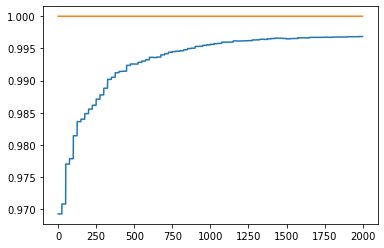

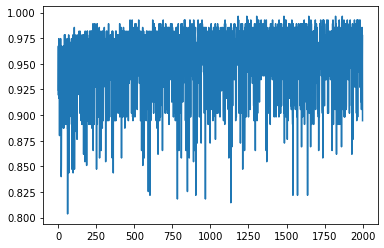

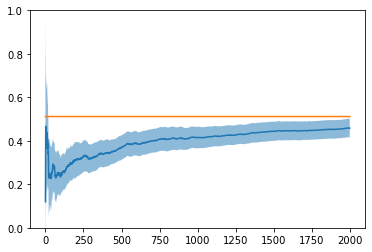

In [203]:
## Plot results for reference. These are not the plots in the paper ##
results = results_rew_max
pihat_oracle_utility = np.vstack([result[0][1] for result in results])
plt.plot(np.mean(pihat_oracle_utility, axis=0)/oracle_utility_rew_max)
plt.plot(np.ones(total_online_pop))
plt.figure()
rewards = np.vstack([result[1][warmup_batch_size:] for result in results]) 
plt.plot(np.mean(rewards, axis=0))
plt.figure()
cum_avg_rews = (np.cumsum(rewards, axis=1) / (np.arange(total_online_pop) + 1)) * (loan_cost+1) - loan_cost
mean_cum_avg_rews = np.mean(cum_avg_rews, axis=0)
ste_cum_avg_rews = stats.sem(cum_avg_rews, axis=0)
plt.plot(mean_cum_avg_rews)
h1 = plt.fill_between(np.arange(total_online_pop), 
                 mean_cum_avg_rews-2*ste_cum_avg_rews, 
                 mean_cum_avg_rews+2*ste_cum_avg_rews,
                alpha=0.5)
plt.plot(np.arange(total_online_pop), np.ones(total_online_pop) * avg_oracle_reward_online)
plt.ylim([0, 1])

In [221]:
## Split population into groups based on age [3 evenly sized percentile buckets] 
# and number of dependents [0, 1, >= 2]

offline_age_group_0_inds = (normalized_offline_pop_features[:, feature_name_list.index("age")] < 1/5)
offline_age_group_1_inds = np.logical_and(
    normalized_offline_pop_features[:, feature_name_list.index("age")] > 1/5,
    normalized_offline_pop_features[:, feature_name_list.index("age")] < 2/5)
offline_age_group_2_inds = np.logical_and(
    normalized_offline_pop_features[:, feature_name_list.index("age")] > 2/5,
    normalized_offline_pop_features[:, feature_name_list.index("age")] < 3/5)
offline_age_group_3_inds = np.logical_and(
    normalized_offline_pop_features[:, feature_name_list.index("age")] > 3/5,
    normalized_offline_pop_features[:, feature_name_list.index("age")] < 4/5)
offline_age_group_4_inds = (normalized_offline_pop_features[:, feature_name_list.index("age")] >4/5)
offline_age_group_inds = [offline_age_group_0_inds, offline_age_group_1_inds, offline_age_group_2_inds,
                         offline_age_group_3_inds, offline_age_group_4_inds]
offline_dep_group_0_inds = offline_pop_features[:, feature_name_list.index("NumberOfDependents")] == 0
offline_dep_group_1_inds = offline_pop_features[:, feature_name_list.index("NumberOfDependents")] == 1
offline_dep_group_2_inds = offline_pop_features[:, feature_name_list.index("NumberOfDependents")] >= 2
offline_dep_group_inds = [offline_dep_group_0_inds, offline_dep_group_1_inds, offline_dep_group_2_inds]
    
def compute_opt_policy_L1_actionable(reward_ests, lambda_g, verbose=False):
    """ Compute policy which maximizes rewards. Takes as input reward estimates and budget constraint. """
    policy_var = cp.Variable((total_offline_pop, num_actions), nonneg=True)
    reward_params = cp.Parameter((total_offline_pop, num_actions), nonneg=True)
    basic_cstrs = [cp.sum(policy_var, axis=1) <= 1]

    avg_per_person_rew = cp.sum(cp.multiply(reward_params, policy_var), axis=1)
    exp_rew = cp.sum(avg_per_person_rew)/total_offline_pop
    
    faster_compile_param = cp.Parameter(nonneg=True)
    faster_compile_param.value = 1
    
    lambda_g_param = cp.Parameter(nonneg=True)
    average_loan_prob = cp.sum(policy_var[:, 1]) / total_offline_pop
    group_loan_probs = [cp.sum(policy_var[:, 1][gis])/np.sum(gis) for gis in offline_age_group_inds + offline_dep_group_inds]
    L1_actionable_disc = sum([cp.abs(group_loan_prob - average_loan_prob) 
                              for group_loan_prob in group_loan_probs])
    
    utility_fn = faster_compile_param*exp_rew - lambda_g_param * L1_actionable_disc
    opt_problem = cp.Problem(cp.Maximize(utility_fn), basic_cstrs)
    
    reward_params.value = reward_ests
    lambda_g_param.value = lambda_g
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        opt_problem.solve(verbose=verbose, solver=cp.ECOS, feastol=1e-4, reltol=1e-4, abstol=1e-4)
    return policy_var.value, utility_fn, reward_params, opt_problem

oracle_policy_L1, utility_fn, reward_params, opt_problem = compute_opt_policy_L1_actionable(
    oracle_offline_rew_preds, 1)
print(np.mean(np.sum(oracle_policy_L1 * oracle_offline_rew_preds, axis=1)))
oracle_utility_L1 = utility_fn.value

0.9557023318636794


In [213]:
avg_oracle_reward_L1 = compute_actual_reward(oracle_policy_L1)
avg_oracle_reward_L1

(0.5129407176696551,
 0.9557218834244177,
 0.005324378764391221,
 0.0004840344331264746)

In [153]:
def L1_large_lambda(reward_ests, verbose=False):
    return compute_opt_policy_L1_actionable(reward_ests, 1, verbose)

result_batch = run_simulation(L1_large_lambda, total_online_pop=2000,
                              batch_size=25, warmup_batch_size=25)

100%|██████████| 2000/2000 [00:14<00:00, 138.60it/s]


In [216]:
## Min Act Disc (L1) Simulation ##
pool = mp.Pool(mp.cpu_count())
num_sims = 25
warmup_batch_size = 25
total_online_pop = 2000
batch_size = 25

results_mad = pool.starmap_async(run_simulation, [
    (L1_large_lambda, total_online_pop, batch_size, warmup_batch_size) for _ in range(num_sims)]).get()
pool.close()

100%|██████████| 2000/2000 [05:10<00:00,  6.43it/s]


(0.0, 1.0)

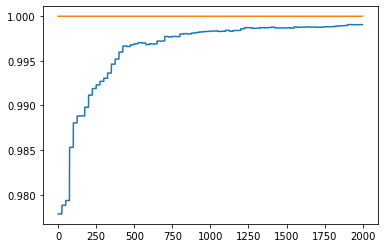

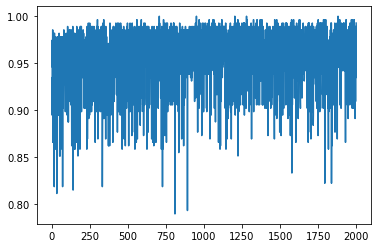

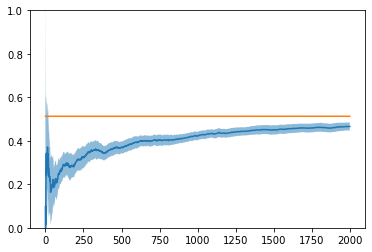

In [223]:
results = results_mad
pihat_oracle_utility = np.vstack([result[0][1] for result in results])
plt.plot(np.mean(pihat_oracle_utility, axis=0)/oracle_utility_L1)
plt.plot(np.ones(total_online_pop))
plt.figure()
rewards = np.vstack([result[1][warmup_batch_size:] for result in results]) 
plt.plot(np.mean(rewards, axis=0))
plt.figure()
cum_avg_rews = (np.cumsum(rewards, axis=1) / (np.arange(total_online_pop) + 1)) * (loan_cost+1) - loan_cost
mean_cum_avg_rews = np.mean(cum_avg_rews, axis=0)
ste_cum_avg_rews = stats.sem(cum_avg_rews, axis=0)
plt.plot(mean_cum_avg_rews)
h1 = plt.fill_between(np.arange(total_online_pop), 
                 mean_cum_avg_rews-2*ste_cum_avg_rews, 
                 mean_cum_avg_rews+2*ste_cum_avg_rews,
                alpha=0.5)
plt.plot(np.arange(total_online_pop), np.ones(total_online_pop) * avg_oracle_reward_L1[0])
plt.ylim([0, 1])

In [224]:
### Compute the actual reward and recourse of the learned policies
actual_rewards_mad = [compute_actual_reward(result[-1]) for result in results_mad]
pool = mp.Pool(mp.cpu_count())
recourses_mad = pool.starmap_async(get_recourse, [
    (result[-1], 10000) for result in results_mad]).get()
pool.close()

100%|██████████| 10000/10000 [04:19<00:00, 38.49it/s]


In [227]:
avg_actual_reward_rm = np.mean(np.array(actual_rewards)[:, 0])
sem_actual_reward_rm = stats.sem(np.array(actual_rewards)[:, 0])
print(avg_actual_reward_rm, sem_actual_reward_rm)

avg_recourse_rm = np.mean(np.array(recourses_rew_max)[:, 0])
sem_recourse_rm = stats.sem(np.array(recourses_rew_max)[:, 0])
print(avg_recourse_rm, sem_recourse_rm)

0.49547996572826164 0.02074084487451011
0.009130731468682901 0.0011674910075396305


In [226]:
avg_actual_reward_mad = np.mean(np.array(actual_rewards_mad)[:, 0])
sem_actual_reward_mad = stats.sem(np.array(actual_rewards_mad)[:, 0])
print(avg_actual_reward_mad, sem_actual_reward_mad)

avg_recourse_mad = np.mean(np.array(recourses_mad)[:, 0])
sem_recourse_mad = stats.sem(np.array(recourses_mad)[:, 0])
print(avg_recourse_mad, sem_recourse_mad)

0.49685022264438705 0.0016289101244226784
0.011132764812256559 0.0007858696865470814


In [228]:
1/avg_recourse_rm/10, 1/avg_recourse_mad/10

(10.952025075207354, 8.982494617141784)

## Code below is for alternative optimization strategies. Ignore for current submission ##

In [218]:
norm_offline_act_features = normalized_offline_pop_features[:, actionable_feature_inds]
norm_online_act_features = normalized_online_pop_features[:, actionable_feature_inds]

def generate_better_feature_id_pairs():
    """ Return list of pairs of indices (person_id, person_w_better_features_id)
    where better features means lower prob of default. """
    id_pairs = []
    for person_id, person_act_feat in enumerate(norm_offline_act_features):
        # Get people who have monotonically `better' features, i.e. less likely to default.
        better_act_feat_inds = np.where(np.logical_and(
            np.sum(person_act_feat >= norm_offline_act_features, axis=1) == num_actionable_features,
            np.sum(person_act_feat == norm_offline_act_features, axis=1) != num_actionable_features))[0]
        id_pairs.extend([(person_id, better_id) for better_id in better_act_feat_inds])
    return id_pairs

def generate_improvement_ids():
    """ Return list of ids of people who can improve their features (wrt offline_pop). """
    ids = []
    for person_id, person_act_feat in tqdm(enumerate(norm_offline_act_features)):
        # Get people who have monotonically `better' features, i.e. less likely to default.
        better_act_feat_inds = np.logical_and(
            np.sum(person_act_feat >= norm_offline_act_features, axis=1) == num_actionable_features,
            np.sum(person_act_feat == norm_offline_act_features, axis=1) != num_actionable_features)
        if np.sum(better_act_feat_inds) > 0:
            ids.append(person_id)
    return ids
# better_feature_id_pairs = generate_better_feature_id_pairs()
# num_pairs = len(better_feature_id_pairs)
improv_offline_ids = generate_improvement_ids()
num_improv_offline_ids = len(improv_offline_ids)

1000it [00:00, 5778.81it/s]


In [219]:
def get_recourse_cvx(policy, num_samples=1000):
    """ Compute delta prob/delta percentile of a policy using the offline pop. """
    recourses = []
    give_loan_probs = policy[:, 1]
    total_num_comparisons = 0
    sampled_ids = np.random.choice(improv_offline_ids, size=num_samples, replace=False)
    for person_id in sampled_ids:
        person_act_feat = norm_online_act_features[person_id]
        person_feat = normalized_online_pop_features[person_id]
        person_give_loan_prob = give_loan_probs[get_nn(person_feat)]
        # Get people who have monotonically `better' features, i.e. less likely to default.
        better_act_feat_inds = np.where(np.logical_and(
            np.sum(person_act_feat >= norm_offline_act_features, axis=1) == num_actionable_features,
            np.sum(np.round(person_act_feat, 4) == np.round(norm_offline_act_features, 4), axis=1) != num_actionable_features))[0]
        better_act_feat_inds = np.random.choice(
            better_act_feat_inds, size=min(num_samples, len(better_act_feat_inds)), replace=False)
        total_num_comparisons += len(better_act_feat_inds)
        better_act_features = norm_offline_act_features[better_act_feat_inds]
        perc_shifts = np.sum(person_act_feat - better_act_features, axis=1) * 100
        better_loan_probs = give_loan_probs[better_act_feat_inds]
        better_delta_probs = better_loan_probs - person_give_loan_prob
        recourse = cp.max(better_delta_probs/perc_shifts)
        recourses.append(recourse)
    return cp.sum(recourses) / num_samples

def compute_opt_policy_recourse(reward_ests, lambda_val, verbose=False, num_samples=1000):
    """ Compute policy which maximizes rewards and considers recourse for those. """
    # Shared policy optimization structure
    policy_var = cp.Variable((total_offline_pop, num_actions), nonneg=True)
    reward_params = cp.Parameter((total_offline_pop, num_actions), nonneg=True)
    
    basic_cstrs = [cp.sum(policy_var, axis=1) <= 1]

    avg_per_person_rew = cp.sum(cp.multiply(reward_params, policy_var), axis=1)
    exp_rew = cp.sum(avg_per_person_rew)/total_offline_pop
    
    faster_compile_param = cp.Parameter(nonneg=True)
    faster_compile_param.value = 1
    
    lambda_param = cp.Parameter(nonneg=True)
    recourse = get_recourse_cvx(policy_var, num_samples=num_samples)
    
    utility_fn = faster_compile_param*exp_rew - lambda_param * recourse
    opt_problem = cp.Problem(cp.Maximize(utility_fn), basic_cstrs)
    
    reward_params.value = reward_ests
    lambda_param.value = lambda_val
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        opt_problem.solve(verbose=verbose, solver=cp.ECOS, feastol=1e-4, reltol=1e-4, abstol=1e-4)
    return policy_var.value, utility_fn, reward_params, opt_problem

oracle_policy_recourse, utility_fn, reward_params, opt_problem = compute_opt_policy_recourse(
    oracle_offline_rew_preds, 100, verbose=False, num_samples=100)
oracle_utility_recourse = utility_fn.value

ValueError: Invalid dimensions (0,).

In [536]:
oracle_utility_recourse

1.281255234279941

In [556]:
print(get_recourse(oracle_policy, num_samples=num_improv_ids))
print(get_recourse(oracle_policy_recourse, num_samples=num_improv_ids))
print(get_recourse(oracle_policy_L1, num_samples=num_improv_ids))

(0.008950124488908914, 5.948658124764468e-05, 2222667)
(0.0047232430043149375, 0.00010962628197242815, 2222667)
(0.009177455281380819, 5.6486056375718676e-05, 2222667)


In [ ]:
oracle_policy_L1

In [555]:
print(np.mean(np.sum(oracle_offline_rew_preds * oracle_policy, axis=1))*(loan_cost + 1) - loan_cost,
     stats.sem(np.sum(oracle_offline_rew_preds * oracle_policy, axis=1)*(loan_cost + 1) - loan_cost))
print(np.mean(np.sum(oracle_offline_rew_preds * oracle_policy_recourse, axis=1))*(loan_cost + 1) - loan_cost,
     stats.sem(np.sum(oracle_offline_rew_preds * oracle_policy_recourse, axis=1)*(loan_cost + 1) - loan_cost))
print(np.mean(np.sum(oracle_offline_rew_preds * oracle_policy_L1, axis=1))*(loan_cost + 1) - loan_cost,
     stats.sem(np.sum(oracle_offline_rew_preds * oracle_policy_L1, axis=1)*(loan_cost + 1) - loan_cost))

0.5308939722892898 0.0046903215426347495
0.3322810519383239 0.009015938285557667
0.5159879844253084 0.004967613777717021


In [546]:
0.5308939722892898 + 0.0046903215426347495

0.5355842938319245

In [558]:
0.3/0.008950124488908914, 0.1/(0.008950124488908914 + 2*5.9486581247644673e-05), 0.1/(0.008950124488908914 - 2*5.9486581247644673e-05)

(33.519086843067164, 11.02645531493606, 11.323551856812141)

In [559]:
0.3/0.009177455281380819, 0.1/(0.009177552509421745 + 2*5.6490288295746606e-05), 0.1/(0.009177552509421745 - 2*5.6490288295746606e-05)

(32.6887999779894, 10.763645000150587, 11.031960553792725)

In [464]:
(31.014687064093373 - 21.65132079202875)/2

4.681683136032312

In [441]:
utilities = []
for _ in tqdm(range(30)):
    policy_val, utility_fn, reward_params, opt_problem = compute_opt_policy_recourse(
        oracle_offline_rew_preds, 500, verbose=False, num_samples=100)
    utilities.append(utility_fn.value)
oracle_utility_recourse = np.mean(utilities)

100%|██████████| 30/30 [00:31<00:00,  1.04s/it]


In [436]:
def recourse_large_lambda(reward_ests, verbose=False):
    return compute_opt_policy_recourse(
    reward_ests, 500, verbose=verbose, num_samples=100)

result_batch = run_simulation(recourse_large_lambda, total_online_pop=5000,
                              balance=False, batch_size=200, warmup_batch_size=25)

100%|██████████| 5000/5000 [01:33<00:00, 53.52it/s]


In [443]:
oracle_utility_recourse, stats.sem(utilities)

(2.9906366698950317, 0.021192540253260447)

(0.0, 1.0)

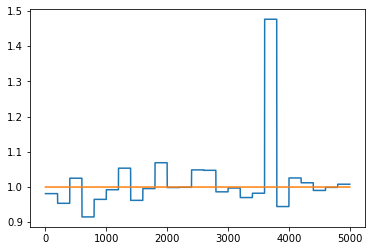

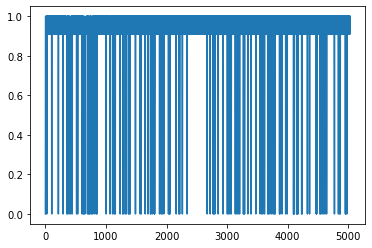

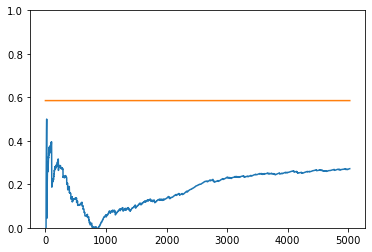

In [444]:
pihat_oracle_utility = np.array(result_batch[0][1])
plt.plot(pihat_oracle_utility/oracle_utility_recourse)
plt.plot(np.ones(pihat_oracle_utility.shape))
plt.figure()
rewards = result_batch[1][1:]
plt.plot(rewards)
plt.figure()
# plt.plot(moving_average(result_batch[1]) * 6 - 5)
plt.plot((np.cumsum(result_batch[1][1:]) / (np.arange(result_batch[1][1:].shape[0]) + 1)) * (loan_cost+1) - loan_cost)
# plt.plot((np.cumsum(result_batch[1][1:]) / (np.arange(result_batch[1][1:].shape[0]) + 1)))
# plt.plot((np.cumsum(result_batch[1][1000:]) / (np.arange(result_batch[1][1000:].shape[0]) + 1)) )
# plt.plot(np.arange(result[1].shape[0]), np.zeros(result[1].shape[0]))
plt.plot(np.arange(result_batch[1].shape[0]), np.ones(result_batch[1].shape[0]) * avg_oracle_reward_online)
# plt.plot(np.arange(result_batch[1].shape[0]), np.ones(result_batch[1].shape[0]) * avg_oracle_norm_reward_online)


plt.ylim([0, 1])

In [38]:
plotter_group(results_rew_max)

TypeError: plotter_group() missing 2 required positional arguments: 'online_group_indicators' and 'group_names'

In [ ]:
### Note: should plot actual rewards, not expected rewards in the misspecified case.